# **1. 데이터 차원**
- 불균형 데이터에 대한 처리 부분 추가  
  -> **가중 무작위 샘플링(Weighted Random Sampling)** 활용
- Albumentation 적용

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - Learning rate Scheduler 활용
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss --- 가중치 적용
- 배치/ Epoch
    - batch size: 64
    - Epoch: 100
    - EarlyStopping 적용(평가 기준: 아마도 f1 score..?)

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **Random Sampling**

In [3]:
### 가중치 함수

def make_weights(df,classes):
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        weight = 1 / count    
        weights = [weight] * count    # 라벨이 뽑힐 가중치를 count의 역수로 동일하게 전체 라벨에 할당 
        weight_list += weights
 
    return weight_list

In [4]:
### 데이터 가져오기
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

In [5]:
### 가중치 생성

feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
weights = make_weights(train_data_df,feelings_list)
# print(weights)

### **DataLoader**

In [6]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [8]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [9]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [10]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    
    weights = make_weights(train_data_df,feelings_list)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,sampler = sampler, drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False,drop_last = False)
    
    return dataloaders

In [11]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [12]:
from torchsummary import summary

In [13]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [14]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [15]:
### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target).to(device) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [16]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [22]:
### 가중 손실 함수

def get_class_weights(df,classes):
    cnt_lists = [] # 각 클래스의 데이터 수 저장
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        cnt_lists.append(count)
    
    weights = [1-(x / sum(cnt_lists)) for x in cnt_lists]
    class_weights = torch.cuda.FloatTensor(weights).to(device) # 가중치 설정
    
    return class_weights


### 가중치 생성
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_weights = get_class_weights(train_data_df,feelings_list)
# print(class_weights)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model()
loss_func = nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean') # 가중 손실 함수
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-10, verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

In [24]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Best Accuracy: {best_acc}')

0/455 - Running loss: 1.9621496200561523
50/455 - Running loss: 1.846749186515808
100/455 - Running loss: 1.8647218942642212
150/455 - Running loss: 1.7069144248962402
200/455 - Running loss: 1.9063624143600464
250/455 - Running loss: 1.872022032737732
300/455 - Running loss: 1.7992364168167114
350/455 - Running loss: 1.753664255142212
400/455 - Running loss: 1.8211592435836792
450/455 - Running loss: 1.7255971431732178
1/100-Train Loss:1.7993907862967187, Val Loss:1.730399213339153
1/100-Train Acc:0.3656936813186813, Val Acc:0.42730170234909304
0/455 - Running loss: 1.7313542366027832
50/455 - Running loss: 1.8171197175979614
100/455 - Running loss: 1.700490117073059
150/455 - Running loss: 1.7149567604064941
200/455 - Running loss: 1.8156533241271973
250/455 - Running loss: 1.710098147392273
300/455 - Running loss: 1.5753782987594604
350/455 - Running loss: 1.7768200635910034
400/455 - Running loss: 1.7152202129364014
450/455 - Running loss: 1.6630200147628784
2/100-Train Loss:1.7118

300/455 - Running loss: 1.7492396831512451
350/455 - Running loss: 1.6890912055969238
400/455 - Running loss: 1.5758172273635864
450/455 - Running loss: 1.6594302654266357
15/100-Train Loss:1.6058427543430538, Val Loss:1.6212242465270192
15/100-Train Acc:0.5746565934065934, Val Acc:0.54170848201011
0/455 - Running loss: 1.5272279977798462
50/455 - Running loss: 1.5525543689727783
100/455 - Running loss: 1.5425633192062378
150/455 - Running loss: 1.7025032043457031
200/455 - Running loss: 1.551759123802185
250/455 - Running loss: 1.6127598285675049
300/455 - Running loss: 1.5383591651916504
350/455 - Running loss: 1.6000146865844727
400/455 - Running loss: 1.6374852657318115
450/455 - Running loss: 1.585746169090271
EarlyStopping counter: 1 out of 10
16/100-Train Loss:1.6044691405453524, Val Loss:1.6314366867667751
16/100-Train Acc:0.5728365384615385, Val Acc:0.5293915402914064
0/455 - Running loss: 1.6606405973434448
50/455 - Running loss: 1.7040129899978638
100/455 - Running loss: 1.6

450/455 - Running loss: 1.587003469467163
EarlyStopping counter: 1 out of 10
29/100-Train Loss:1.5290594703548557, Val Loss:1.5775642269536068
29/100-Train Acc:0.6337225274725274, Val Acc:0.5855913618792744
0/455 - Running loss: 1.4243109226226807
50/455 - Running loss: 1.6043493747711182
100/455 - Running loss: 1.5039653778076172
150/455 - Running loss: 1.5294445753097534
200/455 - Running loss: 1.5884588956832886
250/455 - Running loss: 1.4422723054885864
300/455 - Running loss: 1.5034986734390259
350/455 - Running loss: 1.5531251430511475
400/455 - Running loss: 1.5454432964324951
450/455 - Running loss: 1.5432138442993164
30/100-Train Loss:1.5243687613979802, Val Loss:1.575237566964668
30/100-Train Acc:0.638804945054945, Val Acc:0.5868690529289325
0/455 - Running loss: 1.502572774887085
50/455 - Running loss: 1.5840458869934082
100/455 - Running loss: 1.5408174991607666
150/455 - Running loss: 1.5194741487503052
200/455 - Running loss: 1.3882070779800415
250/455 - Running loss: 1.5

50/455 - Running loss: 1.5814365148544312
100/455 - Running loss: 1.554879903793335
150/455 - Running loss: 1.4055145978927612
200/455 - Running loss: 1.5219721794128418
250/455 - Running loss: 1.3996772766113281
300/455 - Running loss: 1.440476417541504
350/455 - Running loss: 1.4261348247528076
400/455 - Running loss: 1.521743655204773
450/455 - Running loss: 1.382664680480957
44/100-Train Loss:1.4906162031404264, Val Loss:1.558099014717236
44/100-Train Acc:0.6757211538461538, Val Acc:0.6033628828426999
0/455 - Running loss: 1.5649216175079346
50/455 - Running loss: 1.5008175373077393
100/455 - Running loss: 1.5270437002182007
150/455 - Running loss: 1.5981879234313965
200/455 - Running loss: 1.3674099445343018
250/455 - Running loss: 1.5022053718566895
300/455 - Running loss: 1.3969173431396484
350/455 - Running loss: 1.4738119840621948
400/455 - Running loss: 1.425944209098816
450/455 - Running loss: 1.416736125946045
45/100-Train Loss:1.485379994046557, Val Loss:1.5549643018789459

50/455 - Running loss: 1.5832582712173462
100/455 - Running loss: 1.459102749824524
150/455 - Running loss: 1.3983030319213867
200/455 - Running loss: 1.429139256477356
250/455 - Running loss: 1.4261815547943115
300/455 - Running loss: 1.3989789485931396
350/455 - Running loss: 1.4820466041564941
400/455 - Running loss: 1.4533361196517944
450/455 - Running loss: 1.4571623802185059
EarlyStopping counter: 8 out of 10
58/100-Train Loss:1.4582749618278754, Val Loss:1.552773494469492
58/100-Train Acc:0.7046016483516484, Val Acc:0.6085944469223907
0/455 - Running loss: 1.5008199214935303
50/455 - Running loss: 1.4688096046447754
100/455 - Running loss: 1.4562712907791138
150/455 - Running loss: 1.4457635879516602
200/455 - Running loss: 1.4280154705047607
250/455 - Running loss: 1.4314525127410889
300/455 - Running loss: 1.4946095943450928
350/455 - Running loss: 1.4628686904907227
400/455 - Running loss: 1.4117697477340698
450/455 - Running loss: 1.492311954498291
59/100-Train Loss:1.460112

100/455 - Running loss: 1.360480785369873
150/455 - Running loss: 1.3921339511871338
200/455 - Running loss: 1.5513899326324463
250/455 - Running loss: 1.4838166236877441
300/455 - Running loss: 1.4922932386398315
350/455 - Running loss: 1.4828227758407593
400/455 - Running loss: 1.4640909433364868
450/455 - Running loss: 1.5362087488174438
EarlyStopping counter: 7 out of 10
72/100-Train Loss:1.4498528412410192, Val Loss:1.5508347477829247
72/100-Train Acc:0.7132211538461538, Val Acc:0.6116330285459411
0/455 - Running loss: 1.4106370210647583
50/455 - Running loss: 1.508705973625183
100/455 - Running loss: 1.4563652276992798
150/455 - Running loss: 1.564178228378296
200/455 - Running loss: 1.4242793321609497
250/455 - Running loss: 1.4404079914093018
300/455 - Running loss: 1.476050615310669
350/455 - Running loss: 1.4137808084487915
400/455 - Running loss: 1.4792921543121338
450/455 - Running loss: 1.4414584636688232
EarlyStopping counter: 8 out of 10
73/100-Train Loss:1.4514259686836

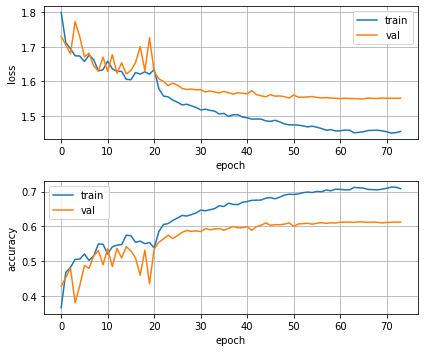

In [25]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()